<p align="center"><b><font size="6"> Macine Learning in practice</b></p>

In [114]:
pip install transformers

Note: you may need to restart the kernel to use updated packages.


In [5]:
from transformers import pipeline

RuntimeError: Failed to import transformers.pipelines because of the following error (look up to see its traceback):
dlopen(/Users/arnaudlamarque/anaconda3/lib/python3.11/site-packages/tensorflow-plugins/libmetal_plugin.dylib, 0x0006): Symbol not found: __ZN3tsl8internal10LogMessageC1EPKcii
  Referenced from: <D2EF42E3-3A7F-39DD-9982-FB6BCDC2853C> /Users/arnaudlamarque/anaconda3/lib/python3.11/site-packages/tensorflow-plugins/libmetal_plugin.dylib
  Expected in:     <2814A58E-D752-317B-8040-131217E2F9AA> /Users/arnaudlamarque/anaconda3/lib/python3.11/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so

In [ ]:
from sklearn.model_selection import train_test_split
import pandas as pd
random_seed = 42
import matplotlib.pyplot as plt


ImportError: cannot import name 'pipeline' from 'transformers' (unknown location)

# Data Processing

In [71]:
# IMDB Movie Reviews
train_path = "Raw Data/IMDB Movie Reviews/train_dataset.csv"
test_path = "Raw Data/IMDB Movie Reviews/test_dataset.csv"
unsupervised_path = "Raw Data/IMDB Movie Reviews/unsupervised_dataset.csv"

IMDB_train = pd.read_csv(train_path)
IMDB_test = pd.read_csv(test_path)
IMDB_unsupervised = pd.read_csv(unsupervised_path)


#Wikipedia Comments
wiki_comments_path = "Raw Data/Wikipedia Personal Attacks/attack_annotated_comments.tsv"
wiki_annotations_path = "Raw Data/Wikipedia Personal Attacks/attack_annotations.tsv"

wiki_comments = pd.read_csv(wiki_comments_path, sep='\t')
wiki_annotations = pd.read_csv(wiki_annotations_path, sep='\t')


In [6]:
IMDB_train

,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0
...,...,...
24995,A hit at the time but now better categorised a...,1
24996,I love this movie like no other. Another time ...,1
24997,This film and it's sequel Barry Mckenzie holds...,1
24998,'The Adventures Of Barry McKenzie' started lif...,1


In [72]:
len(IMDB_test)

25000

In [43]:
wiki_comments

,rev_id,comment,year,logged_in,ns,sample,split
0,37675,`-NEWLINE_TOKENThis is not ``creative``. Thos...,2002,False,article,random,train
1,44816,`NEWLINE_TOKENNEWLINE_TOKEN:: the term ``stand...,2002,False,article,random,train
2,49851,"NEWLINE_TOKENNEWLINE_TOKENTrue or false, the s...",2002,False,article,random,train
3,89320,"Next, maybe you could work on being less cond...",2002,True,article,random,dev
4,93890,This page will need disambiguation.,2002,True,article,random,train
...,...,...,...,...,...,...,...
115859,699848324,`NEWLINE_TOKENNEWLINE_TOKENNEWLINE_TOKENThese ...,2016,True,article,blocked,train
115860,699851288,NEWLINE_TOKENNEWLINE_TOKENThe Institute for Hi...,2016,True,article,blocked,test
115861,699857133,NEWLINE_TOKEN:The way you're trying to describ...,2016,True,article,blocked,train
115862,699891012,NEWLINE_TOKENNEWLINE_TOKEN== Warning ==NEWLINE...,2016,True,user,blocked,dev


In [86]:
wiki_data = wiki_comments

wiki_data["comment"] = wiki_data["comment"].str.replace("NEWLINE_TOKEN", "")
wiki_data = wiki_data.drop(columns=["ns", "sample", "year","rev_id"])
wiki_data = wiki_data.rename(columns={"logged_in": "label"})
wiki_data = wiki_data.rename(columns={"comment": "text"})
wiki_data["label"] = wiki_data["label"].map({False: 0, True: 1})

In [87]:
wiki_data

,text,label,split
0,`-This is not ``creative``. Those are the dic...,0,train
1,`:: the term ``standard model`` is itself less...,0,train
2,"True or false, the situation as of March 2002 ...",0,train
3,"Next, maybe you could work on being less cond...",1,dev
4,This page will need disambiguation.,1,train
...,...,...,...
115859,`These sources don't exactly exude a sense of ...,1,train
115860,The Institute for Historical Review is a peer-...,1,test
115861,:The way you're trying to describe it in this ...,1,train
115862,== Warning ==There is clearly a protectionist ...,1,dev


In [88]:
wiki_train = wiki_data[wiki_data['split'] == 'train']
wiki_train = wiki_train.drop(columns=["split"])
wiki_train
print(wiki_train['label'].value_counts())

wiki_test = wiki_data[wiki_data['split'] == 'test']
wiki_test = wiki_test.drop(columns=["split"])
print(wiki_test['label'].value_counts())

wiki_dev = wiki_data[wiki_data['split'] == 'dev']
wiki_dev = wiki_dev.drop(columns=["split"])
print(wiki_dev['label'].value_counts())

label
1    50846
0    18680
Name: count, dtype: int64
label
1    17262
0     5916
Name: count, dtype: int64
label
1    16810
0     6350
Name: count, dtype: int64


### Unbalanced dataset for IMDB

In [67]:
def unbalanced(df,p):
    df_neg = df[df['label'] == 0]
    df_pos = df[df['label'] == 1]
    
    n_pos = round(len(df_neg)*p/(1-p))
    df_pos = df_pos.sample(n=n_pos)
    df_unbalanced = pd.concat([df_neg, df_pos])

    # Shuffle
    df_unbalanced = df_unbalanced.sample(frac=1, random_state=42)
    
    print(df_unbalanced["label"].value_counts(normalize=True))
    print(len(df_unbalanced))
    return df_unbalanced

In [73]:
p=0.1

IMDB_train_balanced = IMDB_train
IMDB_train_unbalanced = unbalanced(IMDB_train, p)

IMDB_test_2, IMDB_dev =train_test_split(IMDB_test, test_size=0.5, random_state=42)

IMDB_test_balanced = IMDB_test_2
IMDB_test_unbalanced = unbalanced(IMDB_test_2, p)

IMDB_dev_balanced = IMDB_dev
IMDB_dev_unbalanced = unbalanced(IMDB_dev, p)

label
0    0.899993
1    0.100007
Name: proportion, dtype: float64
13889
label
0    0.9
1    0.1
Name: proportion, dtype: float64
6880
label
0    0.899986
1    0.100014
Name: proportion, dtype: float64
7009


In [80]:
imdb_datasets = {
    "train_balanced": IMDB_train_balanced,
    "train_unbalanced": IMDB_train_unbalanced,
    "test_balanced": IMDB_test_balanced,
    "test_unbalanced": IMDB_test_unbalanced,
    "dev_balanced": IMDB_dev_balanced,
    "dev_unbalanced": IMDB_dev_unbalanced
}

### Balanced dataset for Wikipedia

In [89]:
def balanced(df):
    df_neg = df[df['label'] == 0]
    df_pos = df[df['label'] == 1]
    
    n_pos = len(df_neg)
    df_pos=df_pos.sample(n=n_pos)
    df_balanced = pd.concat([df_neg, df_pos])
    
    # Shuffle
    df_balanced = df_balanced.sample(frac=1, random_state=42)
    
    print(df_balanced["label"].value_counts(normalize=True))
    print(len(df_balanced))
    return df_balanced

In [90]:
wiki_train_unbalanced = wiki_train
wiki_test_unbalanced = wiki_test
wiki_dev_unbalanced = wiki_dev

wiki_train_balanced = balanced(wiki_train_unbalanced)
wiki_test_balanced = balanced(wiki_test_unbalanced)
wiki_dev_balanced = balanced(wiki_dev_unbalanced)

label
1    0.5
0    0.5
Name: proportion, dtype: float64
37360
label
1    0.5
0    0.5
Name: proportion, dtype: float64
11832
label
1    0.5
0    0.5
Name: proportion, dtype: float64
12700


In [91]:
wiki_datasets = {
    "train_unbalanced": wiki_train_unbalanced,
    "test_unbalanced": wiki_test_unbalanced,
    "dev_unbalanced": wiki_dev_unbalanced,
    "train_balanced": wiki_train_balanced,
    "test_balanced": wiki_test_balanced,
    "dev_balanced": wiki_dev_balanced,
}

# Naive Bayes

In [78]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import f1_score

def train_and_evaluate_nb(df_train, df_test,n=-1, text_col='text', label_col='label', random_seed=random_seed):

    df_train = df_train.dropna(subset=[text_col])
    df_test = df_test.dropna(subset=[text_col])
    if n > 0:
        df_train = df_train.sample(n=n, random_state=random_seed).reset_index(drop=True)
    # Extraction des textes et labels
    X_train_texts = df_train[text_col]
    y_train = df_train[label_col]

    X_test_texts = df_test[text_col]
    y_test = df_test[label_col]

    # Vectorisation du texte avec TF-IDF
    vectorizer = TfidfVectorizer()
    X_train = vectorizer.fit_transform(X_train_texts)
    X_test = vectorizer.transform(X_test_texts)

    # Entraînement du modèle Naive Bayes
    model_nb = MultinomialNB()
    model_nb.fit(X_train, y_train)

    # Prédictions et évaluation
    preds = model_nb.predict(X_test)
    #print("=== Évaluation du modèle ===")
    #print("Accuracy:", accuracy_score(y_test, preds))
    #print(classification_report(y_test, preds))

    f1_val = f1_score(y_test, preds, average='macro')

    return model_nb, f1_val,



In [79]:
model_nb, f1_scor = train_and_evaluate_nb(IMDB_train, IMDB_test)

print("=== Score F1 ===")
print(f1_scor)

=== Score F1 ===
0.8289532297820281


In [94]:
def plot_model_performance_by_budget(
    datasets_dict,
    model_fn,
    model_name="Naive Bayes",
    labelling_budgets=[16, 32, 64, 128, 256, 512, 1024],
    colors=("blue", "red", "green")
):

    f1_score_Balanced = []
    f1_score_HalfBalanced = []
    f1_score_UnBalanced = []

    for budget in labelling_budgets:
        # (a) Balanced train + balanced test
        _, f1 = model_fn(datasets_dict["train_balanced"], datasets_dict["test_balanced"], budget)
        f1_score_Balanced.append(f1)

        # (b) Balanced train + unbalanced test
        _, f1 = model_fn(datasets_dict["train_balanced"], datasets_dict["test_unbalanced"], budget)
        f1_score_HalfBalanced.append(f1)

        # (c) Unbalanced train + unbalanced test
        _, f1 = model_fn(datasets_dict["train_unbalanced"], datasets_dict["test_unbalanced"], budget)
        f1_score_UnBalanced.append(f1)

    # --- Plotting ---
    fig, axes = plt.subplots(1, 3, figsize=(15, 4), sharey=True)

    axes[0].plot(labelling_budgets, f1_score_Balanced, marker='o', color=colors[0], label=model_name)
    axes[0].set_title('(a) Balanced train and balanced test')
    axes[0].set_xlabel('Labelling budget')
    axes[0].set_ylabel('Macro F1 Score')
    axes[0].set_ylim(0, 1.0)
    axes[0].grid(True)
    axes[0].legend()

    axes[1].plot(labelling_budgets, f1_score_HalfBalanced, marker='o', color=colors[1], label=model_name)
    axes[1].set_title('(b) Balanced train and unbalanced test')
    axes[1].set_xlabel('Labelling budget')
    axes[1].set_ylim(0, 1.0)
    axes[1].grid(True)
    axes[1].legend()

    axes[2].plot(labelling_budgets, f1_score_UnBalanced, marker='o', color=colors[2], label=model_name)
    axes[2].set_title('(c) Unbalanced train and unbalanced test')
    axes[2].set_xlabel('Labelling budget')
    axes[2].set_ylim(0, 1.0)
    axes[2].grid(True)
    axes[2].legend()

    plt.tight_layout()
    plt.show()

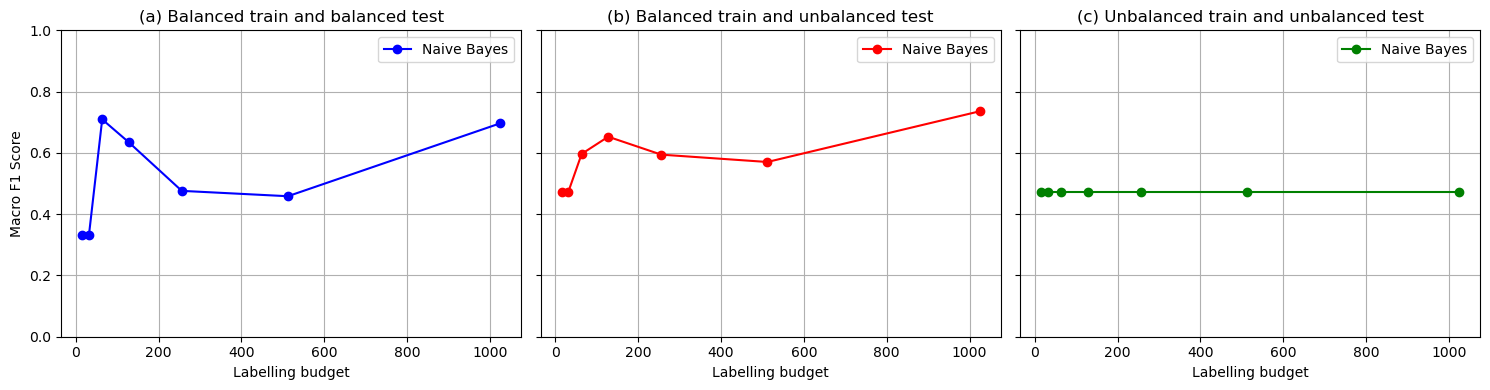

In [95]:
plot_model_performance_by_budget(imdb_datasets,train_and_evaluate_nb)

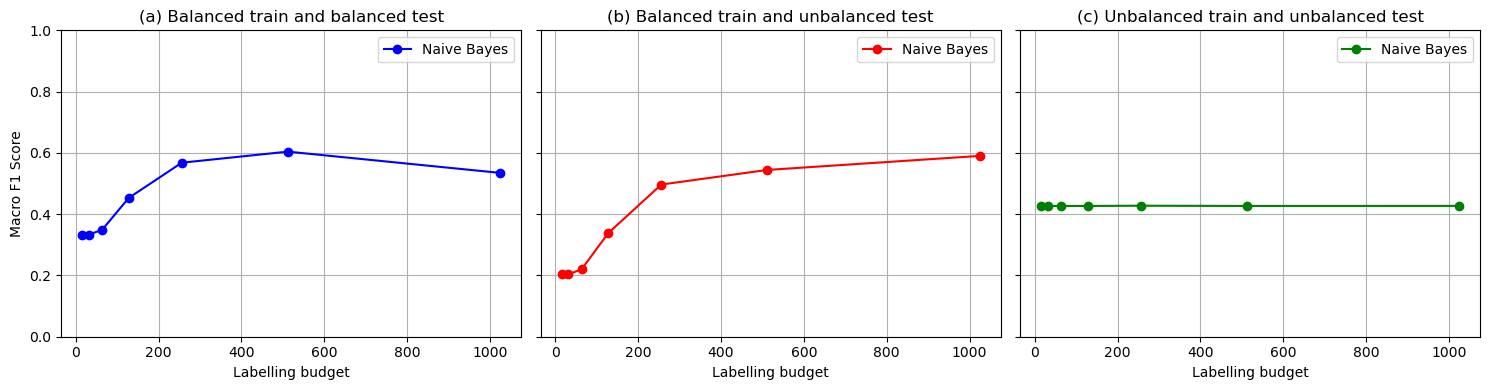

In [96]:
plot_model_performance_by_budget(wiki_datasets,train_and_evaluate_nb)

# Weak Supervision

In [ ]:
def run_weak_supervision_experiment(df_train, df_eval, n_train=-1,
                                      text_col='text', label_col='label',
                                      path_keywords="", path_annotations="",
                                      seed=random_seed, tie_break_policy='random'):
    """
    Exécute la chaîne weak supervision (Snorkel) pour une tâche donnée.

    Paramètres:
      df_train         : DataFrame d'entraînement complet.
      df_eval          : DataFrame d'évaluation complet.
      n_train          : Labelling budget, c'est-à-dire le nombre d'exemples d'entraînement à utiliser.
                         Si n_train > 0, le DataFrame d'entraînement sera réduit par un échantillonnage aléatoire.
      text_col         : Nom de la colonne contenant le texte (par défaut 'text').
      label_col        : Nom de la colonne contenant le label (par défaut 'label').
      path_keywords    : Chemin vers le fichier CSV contenant les keywords.
      path_annotations : Chemin vers le fichier d’annotations (table séparée, par exemple).
      seed             : Graine aléatoire pour la reproductibilité.
      tie_break_policy : Politique de résolution des égalités lors de la prédiction (par exemple, 'random' ou 'abstain').

    Retourne:
      results        : Un dictionnaire contenant le Macro F1 score, le rapport de classification, etc.
      label_model    : Le LabelModel entraîné.

    Remarque:
      Le labelling budget (n_train) définit combien d'exemples annotés seront utilisés pour l'entraînement.
      En variant ce nombre, on peut observer comment la performance du modèle évolue avec davantage
      (ou moins) de données annotées.
    """
    # Convertir les DataFrames dans le format standard (doit produire au moins 'text' et 'label')
    df_train_conv, n_classes_train = convert_labels(df_train)
    df_eval_conv, n_classes_eval = convert_labels(df_eval)

    if n_classes_train != n_classes_eval:
        print("Erreur: le nombre de classes diffère entre train et eval!")
        return None, None

    # Appliquer le labelling budget si spécifié (n_train > 0)
    if n_train > 0:
        df_train_conv = df_train_conv.sample(n=n_train, random_state=seed).reset_index(drop=True)

    # Récupérer les labelling functions via get_lfs (pour binary_abuse dans cet exemple)
    lfs_dict = get_lfs(path_keywords, path_annotations)
    lf_list = [lf for key, lf in lfs_dict.items()]

    # Application des labelling functions sur le jeu d'entraînement
    from snorkel.labeling import PandasLFApplier
    applier = PandasLFApplier(lfs=lf_list)
    L_train = applier.apply(df=df_train_conv)

    # Entraîner le LabelModel
    from snorkel.labeling.model.label_model import LabelModel
    label_model = LabelModel(cardinality=n_classes_train, verbose=False)
    label_model.fit(L_train=L_train, n_epochs=100, log_freq=10, seed=seed)

    # Appliquer les labelling functions sur le jeu d'évaluation
    L_eval = applier.apply(df=df_eval_conv)
    Y_eval = df_eval_conv[label_col].values

    # Prédiction avec la politique de tie break
    preds = label_model.predict(L_eval, tie_break_policy=tie_break_policy)

    # Calcul des métriques d'évaluation
    from sklearn.metrics import f1_score, classification_report
    f1_val = f1_score(Y_eval, preds, average='macro', zero_division=0)
    report = classification_report(Y_eval, preds)

    results = {
        "f1_score": f1_val,
        "classification_report": report,
        "predictions": preds,
        "true_labels": Y_eval,
    }

    return results, label_model

# Exemple d'utilisation :
# Supposons que vos DataFrames 'binary_abuse_train' et 'binary_abuse_dev' sont déjà chargés dans le notebook.
# Remplacez path_keywords et path_annotations par les chemins correspondants.

results, label_model = run_weak_supervision_experiment(
    df_train=binary_abuse_train,
    df_eval=binary_abuse_dev,
    n_train=1024,  # Par exemple, utiliser 1024 exemples d'entraînement pour simuler le labelling budget.
    text_col='text',
    label_col='label',
    path_keywords="data/binary_abuse/misc/keywords.csv",
    path_annotations="data/binary_abuse/raw_data/annotations.csv",
    seed=42,
    tie_break_policy='random'
)

print("Macro F1 score (weak supervision):", results["f1_score"])
print("\nClassification Report:\n", results["classification_report"])

NameError: name 'convert_labels' is not defined

# Transfer Learning

In [107]:
from transformers import pipeline
import torch

classifier = pipeline(
    task="text-classification",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    torch_dtype=torch.float16,
    device=0  # ou -1 pour CPU
)

ImportError: cannot import name 'pipeline' from 'transformers' (unknown location)

In [103]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification, Trainer, TrainingArguments
from datasets import Dataset
import pandas as pd

# 1. Charger ton dataset IMDB
# Supposons que tu as déjà un DataFrame df_train et df_test avec colonnes 'text' et 'label'

# 2. Convertir en HuggingFace Dataset
train_dataset = Dataset.from_pandas(df_train)
test_dataset = Dataset.from_pandas(df_test)

# 3. Charger le tokenizer DistilBERT
tokenizer = DistilBertTokenizerFast.from_pretrained("distilbert-base-uncased")

# 4. Tokenizer les exemples

def preprocess_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True)

train_dataset = train_dataset.map(preprocess_function, batched=True)
test_dataset = test_dataset.map(preprocess_function, batched=True)

# 5. Charger le modèle pour la classification binaire
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=2)

# 6. Arguments d'entraînement
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    logging_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    load_best_model_at_end=True,
)

# 7. Définir le trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
)

# 8. Entraînement
trainer.train()

# 9. Évaluation finale
metrics = trainer.evaluate()
print(metrics)


ImportError: cannot import name 'DistilBertTokenizerFast' from 'transformers' (unknown location)

# Prompt Engineering